# Variance Swap Pricing Summary

Consider an asset following the risk-neutral dynamics with a time-varying volatility $ \sigma(t) $ and zero dividend yield:

$$
\frac{dS_t}{S_t} = r \, dt + \sigma(t) \, dW_t.
$$

Taking logs with $ X_t = \log S_t $ and applying Itô’s lemma, we obtain:

$$
dX_t = \left(r - \frac{1}{2}\sigma(t)^2\right)dt + \sigma(t) \, dW_t.
$$

The realized variance over $ [0, T] $ (in the continuous limit) is given by the quadratic variation:

$$
[\log S]_T = \int_0^T \sigma(t)^2 \, dt.
$$

For discrete sampling, the realized variance is approximated by:

$$
\text{Realized Variance} \approx \sum_{i=1}^{n} \left(\log \frac{S(t_i)}{S(t_{i-1})}\right)^2.
$$

The fair strike $ K $ of the variance swap is set so that the expected (risk-neutral) payoff is zero. Hence, it satisfies:

$$
K = \mathbb{E}\left[\text{Realized Variance}\right] = \int_0^T \sigma(t)^2 \, dt.
$$

The variance swap payoff (per unit notional) is defined as:

$$
\text{Payoff} = \text{Realized Variance} - K.
$$

Discounting the payoff back to time zero using the risk-free rate $ r $, the present value (PV) of the variance swap is:

$$
\text{Swap Price} = e^{-rT}\left(\mathbb{E}\left[\text{Realized Variance}\right]-K\right) \approx 0,
$$

when the strike is set fairly as above.


############################################

########### Code Explain ###################

############################################

# Code Functioning Summary

The code performs three main tasks: a Monte Carlo simulation of the asset path, an analytical calculation of the fair variance swap strike, and a comparison of the two approaches. Below is a summary of each component:

---

### 1. Monte Carlo Simulation

The asset is assumed to follow the risk-neutral dynamics with a time-varying volatility:
$$
\frac{dS_t}{S_t} = r\, dt + \sigma(t)\, dW_t,
$$
with
$$
\sigma(t) = 0.20 + 0.05\, \sin\left(\frac{2\pi t}{T}\right),
$$
where $ T $ is the maturity of the swap.

The log return over a small interval $ \Delta t $ is computed as:
$$
\Delta \log S = \left(r - \frac{1}{2} \sigma(t)^2\right) \Delta t + \sigma(t) \sqrt{\Delta t} \, Z,
$$
with $ Z \sim \mathcal{N}(0,1) $.

For each simulated path, the realized variance is approximated by:
$$
\text{Realized Variance} \approx \sum_{i=1}^{n_{\text{steps}}} \left(\Delta \log S_i\right)^2.
$$
The Monte Carlo simulation averages these values over all paths to estimate the expected realized variance.

---

### 2. Analytical Pricing

The fair strike $ K $ for the variance swap is the risk-neutral expectation of the integrated variance:
$$
K = \int_0^T \sigma(t)^2 \, dt.
$$
This integral is computed numerically (using the trapezoidal method) over the discrete time grid.

---

### 3. Swap Pricing and Comparison

The payoff of the variance swap (per unit notional) is defined as:
$$
\text{Payoff} = \text{Realized Variance} - K.
$$

The present value (price) of the swap is given by discounting the expected payoff:
$$
\text{Swap Price} = e^{-rT}\,\mathbb{E}\left[\text{Payoff}\right].
$$

When the swap is fairly priced (i.e., when $ K $ equals the expected realized variance), the swap price should be close to zero.

---

### 4. Visualization

Finally, the code plots a sample of simulated asset price paths $ S_t $ to illustrate the evolution of the process with time-varying volatility.


Monte Carlo Mean Realized Variance: 0.041260
Analytical Integrated Variance (K): 0.041250
Discounted Variance Swap Price (should be close to 0): 0.000009


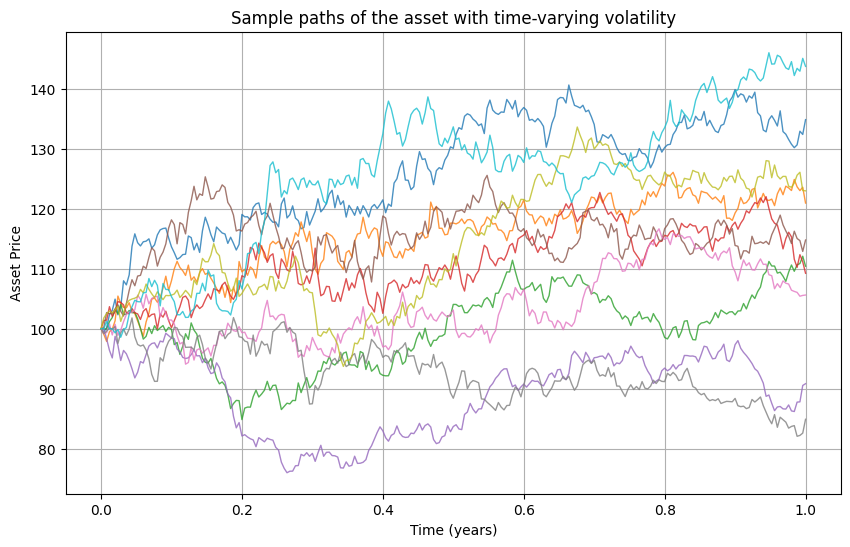

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time-varying volatility function, sigma(t)
def sigma(t, T):
    # For example: sigma oscillates around 0.20 with amplitude 0.05
    return 0.20 + 0.05 * np.sin(2 * np.pi * t / T)

# Set model and simulation parameters
T = 1.0            # Maturity in years
n_steps = 250      # Number of time steps
dt = T / n_steps   # Time step
S0 = 100.0         # Initial asset price
r = 0.05           # Risk-free rate (annual)
n_sims = 100000    # Number of Monte Carlo simulation paths

# Create a time grid from 0 to T
times = np.linspace(0, T, n_steps + 1)

# Evaluate sigma at the discrete times (note: we'll need sigma for each interval step)
# Using times[:-1] because the log return over the interval [t, t+dt] is driven by sigma at time t.
sigma_vals = sigma(times[:-1], T)  # This is a vector of length n_steps

# ---------------------------
# Monte Carlo Simulation
# ---------------------------
# Generate standard normal random numbers for each simulation and each time step.
# Z has dimensions (n_sims, n_steps)
Z = np.random.normal(size=(n_sims, n_steps))

# Calculate the log returns over each time step.
# Under the risk-neutral dynamics for an asset with time-varying volatility:
# log(S_{t+dt}/S_t) = (r - 0.5 * sigma(t)^2) * dt + sigma(t) * sqrt(dt) * Z
log_returns = (r - 0.5 * sigma_vals**2) * dt + sigma_vals * np.sqrt(dt) * Z

# For each simulation, compute the realized variance as the sum of squared log returns.
# (This approximates the quadratic variation of log S_t.)
realized_variances = np.sum(log_returns**2, axis=1)

# The Monte Carlo estimate is the average over all simulation paths.
MC_mean_RV = np.mean(realized_variances)

# ---------------------------
# Analytical Calculation
# ---------------------------
# Compute the integrated variance K = ∫_0^T sigma(t)^2 dt using the trapezoidal rule.
# We evaluate sigma^2 at all time grid points.
analytic_RV = np.trapezoid(sigma(times, T)**2, times)

# ---------------------------
# Price the Variance Swap
# ---------------------------
# In a variance swap, the payoff (per unit notional) is:
#    Payoff = Realized Variance - K.
# Here K is set to the analytical (or expected) integrated variance.
K = analytic_RV   # Fair strike
payoffs = realized_variances - K

# Discount the average payoff back to time zero.
discount_factor = np.exp(-r * T)
swap_price = discount_factor * np.mean(payoffs)

# ---------------------------
# Output the Results
# ---------------------------
print("Monte Carlo Mean Realized Variance: {:.6f}".format(MC_mean_RV))
print("Analytical Integrated Variance (K): {:.6f}".format(analytic_RV))
print("Discounted Variance Swap Price (should be close to 0): {:.6f}".format(swap_price))

# ---------------------------
# Optional: Plot a few simulated log-price paths
# ---------------------------
num_paths_to_plot = 10
S_paths = np.zeros((num_paths_to_plot, n_steps + 1))
for i in range(num_paths_to_plot):
    # Generate one path using cumulative sum of log returns
    log_S = np.log(S0) + np.cumsum(np.insert(log_returns[i, :], 0, 0))
    S_paths[i, :] = np.exp(log_S)

plt.figure(figsize=(10, 6))
for path in S_paths:
    plt.plot(times, path, lw=1, alpha=0.8)
plt.xlabel("Time (years)")
plt.ylabel("Asset Price")
plt.title("Sample paths of the asset with time-varying volatility")
plt.grid(True)
plt.show()
